# Analisis resultados simulacion Prototipo 1
Resumen ampliado de retrasos, colas y capacidad a partir de los ficheros de resultados.


## Importacion de librerias


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


## Carga de datos de CSV de salida


In [34]:

import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / 'prototipos').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from prototipos.prototipo1.core.configuracion import generar_aeropuertos_demo, obtener_posiciones

DATA_DIR = PROJECT_ROOT / 'prototipos' / 'prototipo1'
path_csv_eventos = DATA_DIR / 'registros_todos_eventos.csv'
path_csv_resultados = DATA_DIR / 'registros_todos.csv'

logs_eventos = pd.read_csv(path_csv_eventos)
resultados_eventos = pd.read_csv(path_csv_resultados)

# Posiciones y capacidades de aeropuertos para calculos de distancia/capacidad
catalogo_aeropuertos = generar_aeropuertos_demo()
posiciones = obtener_posiciones(catalogo_aeropuertos)
capacidades = {ident: cap for ident, _, cap in catalogo_aeropuertos}

logs_eventos.head(), resultados_eventos.head()


(   N_simulacion     tipo id_vuelo origen destino  minuto  retraso
 0             1   salida    IE037      I       E       8      NaN
 1             1   salida    CJ033      C       J      33      NaN
 2             1  llegada    CJ033      C       J      48      0.0
 3             1  llegada    IE037      I       E      72      0.0
 4             1   salida    IH044      I       H      99      NaN,
    N_simulacion id_vuelo aeropuerto_origen aeropuerto_destino hora_salida  \
 0             1    CJ033                 C                  J       00:33   
 1             1    IE037                 I                  E       00:08   
 2             1    IH044                 I                  H       01:39   
 3             1    AD020                 A                  D       02:59   
 4             1    CI024                 C                  I       03:27   
 
   hora_llegada_programada hora_llegada_real  retraso_minutos  
 0                   00:48             00:48                0  

## Preparacion de variables de tiempo
Convertimos los campos HH:MM a minutos para poder calcular duraciones y retrasos de forma directa.


In [35]:
def hhmm_to_minute(value: str) -> int:
    hora, minuto = value.split(':')
    return int(hora) * 60 + int(minuto)

resultados_eventos['salida_min'] = resultados_eventos['hora_salida'].apply(hhmm_to_minute)
resultados_eventos['llegada_prog_min'] = resultados_eventos['hora_llegada_programada'].apply(hhmm_to_minute)
resultados_eventos['llegada_real_min'] = resultados_eventos['hora_llegada_real'].apply(hhmm_to_minute)

resultados_eventos['duracion_real_min'] = resultados_eventos['llegada_real_min'] - resultados_eventos['salida_min']
resultados_eventos['retraso_calculado'] = resultados_eventos['llegada_real_min'] - resultados_eventos['llegada_prog_min']
resultados_eventos['hora_salida_h'] = resultados_eventos['salida_min'] // 60

puntuales = (resultados_eventos['retraso_calculado'] <= 0)
print(f"Vuelos totales: {len(resultados_eventos)}")
print(f"Puntuales: {puntuales.sum()} ({puntuales.mean():.2%})")


Vuelos totales: 2777
Puntuales: 2575 (92.73%)


## 1. Retrasos: distribucion, percentiles y horas pico


Percentiles retraso (min):
0.50      0.00
0.90      0.00
0.95    103.20
0.99    398.92
Name: retraso_calculado, dtype: float64
Proporcion de vuelos con retraso sobre umbrales:
  > 0 min: 7.27%
  > 15 min: 6.88%
  > 30 min: 6.59%
  > 60 min: 5.91%


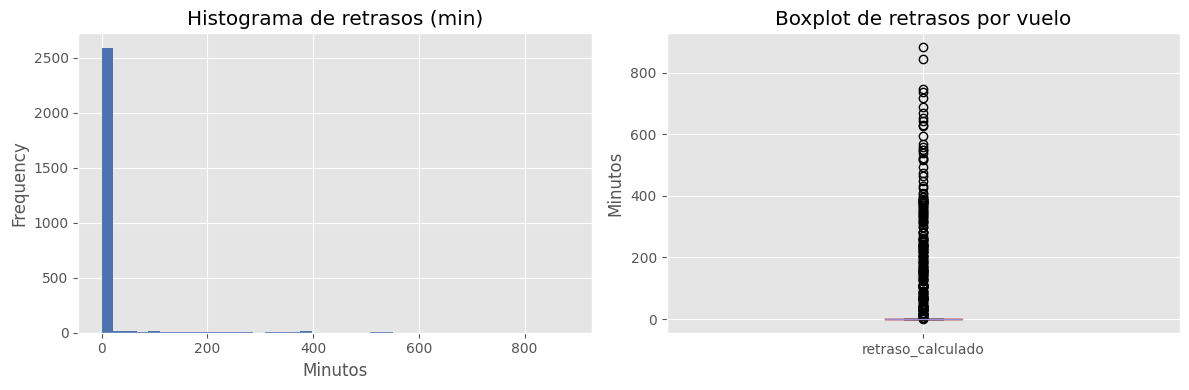

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

resultados_eventos['retraso_calculado'].plot(kind='hist', bins=40, ax=axes[0], color='#4c72b0')
axes[0].set_title('Histograma de retrasos (min)')
axes[0].set_xlabel('Minutos')

resultados_eventos.boxplot(column='retraso_calculado', ax=axes[1])
axes[1].set_title('Boxplot de retrasos por vuelo')
axes[1].set_ylabel('Minutos')

plt.tight_layout()

percentiles = resultados_eventos['retraso_calculado'].quantile([0.5, 0.9, 0.95, 0.99])
print('Percentiles retraso (min):')
print(percentiles)

umbrales = [0, 15, 30, 60]
por_umbral = {f"> {u} min": (resultados_eventos['retraso_calculado'] > u).mean() for u in umbrales}
print('Proporcion de vuelos con retraso sobre umbrales:')
for k, v in por_umbral.items():
    print(f"  {k}: {v:.2%}")


### Retraso segun hora de salida


,media,p90
hora_salida_h,,
0,0.000000,0.0
1,5.360000,0.0
2,0.000000,0.0
3,3.017241,0.0
4,12.714286,0.0
5,23.992424,0.0
6,15.718310,0.0
7,31.447154,0.0
8,38.710526,103.7


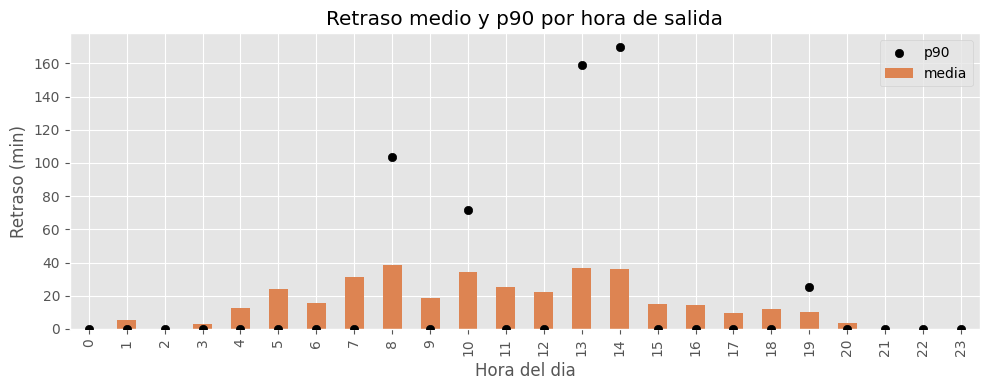

In [65]:
retraso_por_hora = resultados_eventos.groupby('hora_salida_h')['retraso_calculado'].agg(
    media='mean',
    p90=lambda x: x.quantile(0.9)
)

ax = retraso_por_hora['media'].plot(kind='bar', figsize=(10, 4), color='#dd8452', label='media')

# p90 como puntos (sin líneas) para no sugerir interpolación entre horas
x = range(len(retraso_por_hora.index))
ax.scatter(x, retraso_por_hora['p90'].values, color='black', marker='o', label='p90', zorder=3)

plt.title('Retraso medio y p90 por hora de salida')
plt.xlabel('Hora del dia')
plt.ylabel('Retraso (min)')
plt.legend()
plt.tight_layout()

retraso_por_hora


## 2. Comparacion entre aeropuertos


Retraso medio por aeropuerto de origen:
                   retraso_medio  retraso_max
aeropuerto_origen                            
G                      27.118705          745
F                      22.290780          737
B                      20.888476          844
I                      20.426523          652
H                      16.582759          644
C                      13.101754          668
A                      12.200680          396
D                      11.679842          883
E                      10.919298          518
J                       9.412214          558
Retraso medio por aeropuerto de destino:
                    retraso_medio  retraso_max  vuelos_totales
aeropuerto_destino                                            
D                       48.531120          844             494
E                       39.952555          745             559
C                       28.011236          518             552
I                       19.295302          737      

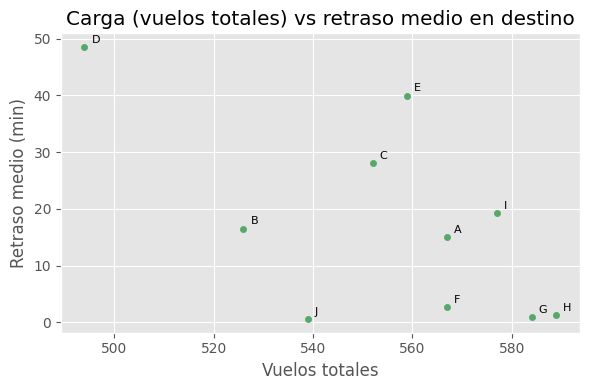

In [38]:

# Retraso por aeropuerto de origen y destino
retraso_origen = resultados_eventos.groupby('aeropuerto_origen')['retraso_calculado'].agg(retraso_medio='mean', retraso_max='max')
retraso_destino = resultados_eventos.groupby('aeropuerto_destino')['retraso_calculado'].agg(retraso_medio='mean', retraso_max='max')

# Carga total (salidas + llegadas)
trafico = resultados_eventos.groupby('aeropuerto_origen')['id_vuelo'].count().rename('salidas').to_frame()
trafico['llegadas'] = resultados_eventos.groupby('aeropuerto_destino')['id_vuelo'].count()
trafico['vuelos_totales'] = trafico['salidas'] + trafico['llegadas']

# Relacion carga vs retraso medio en destino
retraso_destino = retraso_destino.join(trafico['vuelos_totales'], how='left')

print('Retraso medio por aeropuerto de origen:')
print(retraso_origen.sort_values('retraso_medio', ascending=False))
print('Retraso medio por aeropuerto de destino:')
print(retraso_destino.sort_values('retraso_medio', ascending=False))

ax = retraso_destino.plot.scatter(x='vuelos_totales', y='retraso_medio', figsize=(6,4), color='#55a868')
ax.set_title('Carga (vuelos totales) vs retraso medio en destino')
ax.set_xlabel('Vuelos totales')
ax.set_ylabel('Retraso medio (min)')

# Mostrar etiquetas con el nombre del aeropuerto
for aeropuerto, row in retraso_destino.iterrows():
    ax.annotate(aeropuerto, (row['vuelos_totales'], row['retraso_medio']),
                xytext=(5, 3), textcoords='offset points', fontsize=8)

plt.tight_layout()


## 3. Variabilidad entre escenarios


C:\Users\alvar\AppData\Local\Temp\ipykernel_18636\3338154616.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  retraso_por_escenario['pct_vuelos_retrasados'] = resultados_eventos.groupby('N_simulacion').apply(lambda df: (df['retraso_calculado'] > 0).mean())


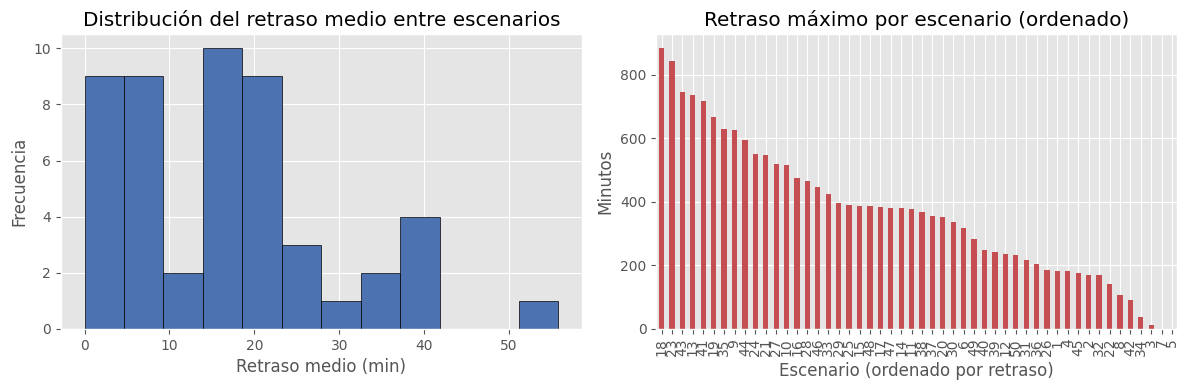

In [39]:
retraso_por_escenario = resultados_eventos.groupby('N_simulacion')['retraso_calculado'].agg(
    media_retraso='mean', max_retraso='max', std_retraso='std')
retraso_por_escenario['pct_vuelos_retrasados'] = resultados_eventos.groupby('N_simulacion').apply(lambda df: (df['retraso_calculado'] > 0).mean())

retraso_por_escenario.head()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# (1) HISTOGRAMA del retraso medio entre escenarios
axes[0].hist(
    retraso_por_escenario['media_retraso'],
    bins=12,
    color='#4c72b0',
    edgecolor='black'
)
axes[0].set_title('Distribución del retraso medio entre escenarios')
axes[0].set_xlabel('Retraso medio (min)')
axes[0].set_ylabel('Frecuencia')

# (2) Retraso máximo por escenario ORDENADO de mayor a menor
retraso_ordenado = retraso_por_escenario.sort_values(
    by='max_retraso',
    ascending=False
)

retraso_ordenado['max_retraso'].plot(
    kind='bar',
    ax=axes[1],
    color='#c44e52'
)

axes[1].set_title('Retraso máximo por escenario (ordenado)')
axes[1].set_xlabel('Escenario (ordenado por retraso)')
axes[1].set_ylabel('Minutos')

plt.tight_layout()


## 4. Colas y tiempos de espera


Top aeropuertos por longitud maxima de cola:
            vuelos_en_cola  espera_media_min  espera_max_min  \
aeropuerto                                                     
E                       36        304.083333           745.0   
B                       17        250.235294           629.0   
C                       36        207.750000           518.0   
D                       50        233.920000           844.0   
A                       22        186.000000           883.0   
F                        4        188.500000           378.0   
I                       28        205.357143           737.0   
J                        3         55.000000           133.0   

            longitud_max_cola  
aeropuerto                     
E                           8  
B                           6  
C                           6  
D                           6  
A                           5  
F                           5  
I                           5  
J                         

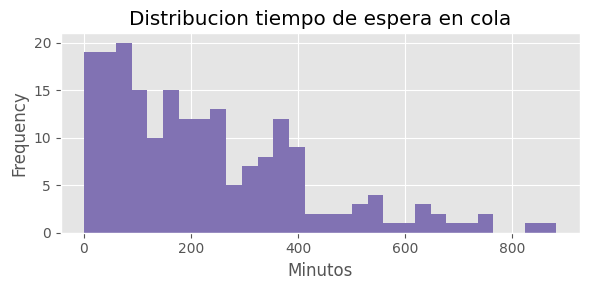

In [40]:

colas = (logs_eventos[logs_eventos['tipo'] == 'cola_espera']
    [['N_simulacion', 'id_vuelo', 'destino', 'minuto']]
    .rename(columns={'minuto': 'minuto_cola', 'destino': 'aeropuerto'}))

llegadas = (logs_eventos[logs_eventos['tipo'] == 'llegada']
    [['N_simulacion', 'id_vuelo', 'destino', 'minuto']]
    .rename(columns={'minuto': 'minuto_llegada', 'destino': 'aeropuerto'}))

colas = colas.merge(llegadas, on=['N_simulacion', 'id_vuelo', 'aeropuerto'], how='left')
colas['espera_min'] = colas['minuto_llegada'] - colas['minuto_cola']

cola_por_aeropuerto = colas.groupby('aeropuerto')['espera_min'].agg(vuelos_en_cola='count', espera_media_min='mean', espera_max_min='max')
cola_por_aeropuerto.sort_values('espera_media_min', ascending=False).head(10)

# Longitud maxima de colas por aeropuerto y escenario
max_cola = {}
for (esc, aeropuerto), grupo in colas.groupby(['N_simulacion', 'aeropuerto']):
    cambios = []
    for _, row in grupo.iterrows():
        cambios.append((row['minuto_cola'], 1))
        if pd.notna(row['minuto_llegada']):
            cambios.append((row['minuto_llegada'], -1))
    en_cola = max_en_cola = 0
    for _, delta in sorted(cambios, key=lambda x: x[0]):
        en_cola += delta
        max_en_cola = max(max_en_cola, en_cola)
    max_cola[(esc, aeropuerto)] = max_en_cola

cola_por_aeropuerto_esc = pd.Series(max_cola).rename('longitud_max_cola').reset_index()
cola_por_aeropuerto_esc.columns = ['N_simulacion', 'aeropuerto', 'longitud_max_cola']

cola_por_aeropuerto = cola_por_aeropuerto.join(
    cola_por_aeropuerto_esc.groupby('aeropuerto')['longitud_max_cola'].max())

print('Top aeropuertos por longitud maxima de cola:')
print(cola_por_aeropuerto.sort_values('longitud_max_cola', ascending=False).head(8))

colas['espera_min'].dropna().plot(kind='hist', bins=30, figsize=(6,3), color='#8172b3', title='Distribucion tiempo de espera en cola')
plt.xlabel('Minutos')
plt.tight_layout()


### Evolucion temporal de colas (escenario con mayor cola)


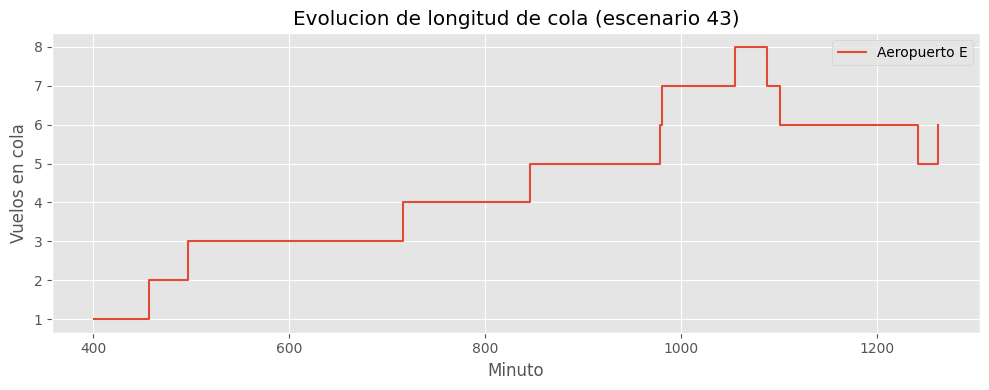

In [41]:
# Elegimos el escenario con mayor cola maxima
escenario_max_cola = cola_por_aeropuerto_esc.sort_values('longitud_max_cola', ascending=False).iloc[0]['N_simulacion']
aeropuerto_max_cola = cola_por_aeropuerto_esc.sort_values('longitud_max_cola', ascending=False).iloc[0]['aeropuerto']

series = []
for aeropuerto in [aeropuerto_max_cola]:
    cambios = []
    subset = colas[(colas['N_simulacion'] == escenario_max_cola) & (colas['aeropuerto'] == aeropuerto)]
    for _, row in subset.iterrows():
        cambios.append((row['minuto_cola'], 1))
        if pd.notna(row['minuto_llegada']):
            cambios.append((row['minuto_llegada'], -1))
    puntos = []
    en_cola = 0
    for minuto, delta in sorted(cambios, key=lambda x: x[0]):
        en_cola += delta
        puntos.append((minuto, en_cola))
    series.append((aeropuerto, puntos))

plt.figure(figsize=(10,4))
for aeropuerto, puntos in series:
    minutos, valores = zip(*puntos)
    plt.step(minutos, valores, where='post', label=f'Aeropuerto {aeropuerto}')
plt.title(f'Evolucion de longitud de cola (escenario {escenario_max_cola})')
plt.xlabel('Minuto')
plt.ylabel('Vuelos en cola')
plt.legend()
plt.tight_layout()


## 5. Relacion entre distancia y retraso


Correlacion distancia-retraso: 0.019


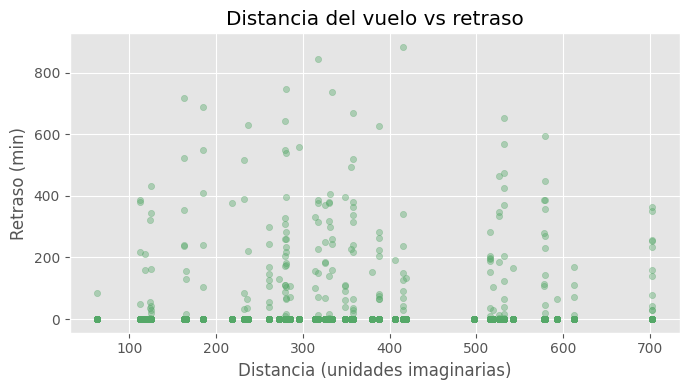

In [42]:
def distancia(origen: str, destino: str) -> float:
    return float(np.linalg.norm(np.array(posiciones[origen]) - np.array(posiciones[destino])))

resultados_eventos['distancia'] = resultados_eventos.apply(
    lambda r: distancia(r['aeropuerto_origen'], r['aeropuerto_destino']), axis=1)

ax = resultados_eventos.plot.scatter(x='distancia', y='retraso_calculado', figsize=(7,4), alpha=0.4, color='#55a868')
plt.title('Distancia del vuelo vs retraso')
plt.xlabel('Distancia (unidades imaginarias)')
plt.ylabel('Retraso (min)')
plt.tight_layout()

corr = resultados_eventos[['distancia', 'retraso_calculado']].corr().iloc[0,1]
print(f'Correlacion distancia-retraso: {corr:.3f}')


## 6. Perfil de aeropuertos concretos


Aeropuerto con mas vuelos: H
Aeropuerto con menos vuelos: D


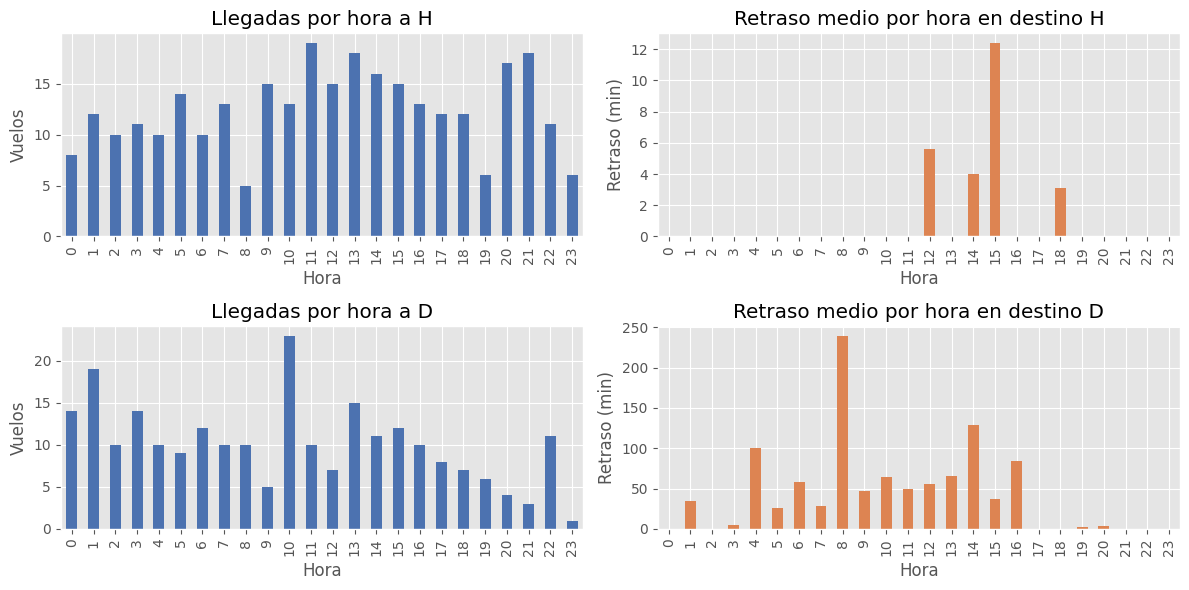

In [43]:
# Elegimos un aeropuerto muy cargado y uno ligero
mas_cargado = trafico.sort_values('vuelos_totales', ascending=False).index[0]
menos_cargado = trafico.sort_values('vuelos_totales', ascending=True).index[0]
print('Aeropuerto con mas vuelos:', mas_cargado)
print('Aeropuerto con menos vuelos:', menos_cargado)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for ax_row, aeropuerto in zip(axes, [mas_cargado, menos_cargado]):
    subset = resultados_eventos[resultados_eventos['aeropuerto_destino'] == aeropuerto]
    subset.groupby('hora_salida_h')['id_vuelo'].count().plot(kind='bar', ax=ax_row[0], color='#4c72b0')
    ax_row[0].set_title(f'Llegadas por hora a {aeropuerto}')
    ax_row[0].set_xlabel('Hora')
    ax_row[0].set_ylabel('Vuelos')

    subset.groupby('hora_salida_h')['retraso_calculado'].mean().plot(kind='bar', ax=ax_row[1], color='#dd8452')
    ax_row[1].set_title(f'Retraso medio por hora en destino {aeropuerto}')
    ax_row[1].set_xlabel('Hora')
    ax_row[1].set_ylabel('Retraso (min)')

plt.tight_layout()


## 7. Descomponer retraso: congestion vs planificacion


       retraso_calculado  espera_en_cola  retraso_sin_cola
count        2777.000000     2777.000000            2777.0
mean           16.494779       16.494779               0.0
std            77.385916       77.385916               0.0
min             0.000000        0.000000               0.0
25%             0.000000        0.000000               0.0
50%             0.000000        0.000000               0.0
75%             0.000000        0.000000               0.0
max           883.000000      883.000000               0.0


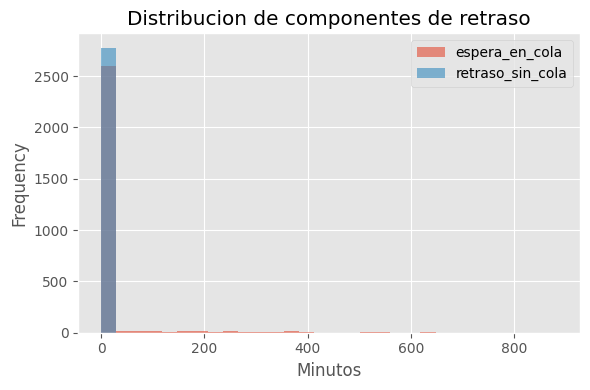

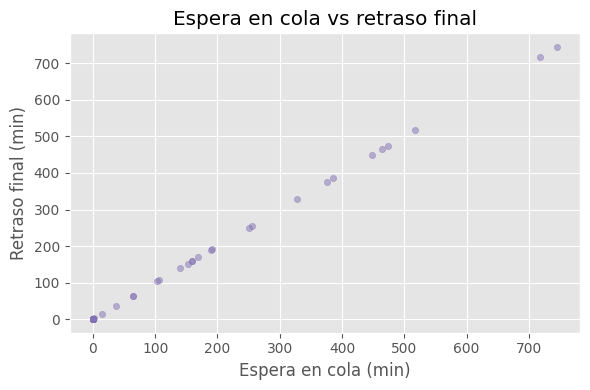

In [44]:
# Espera en cola por vuelo
espera_por_vuelo = colas.groupby(['N_simulacion', 'id_vuelo'])['espera_min'].sum().rename('espera_en_cola')

resultados_eventos = resultados_eventos.merge(espera_por_vuelo, on=['N_simulacion', 'id_vuelo'], how='left')
resultados_eventos['espera_en_cola'] = resultados_eventos['espera_en_cola'].fillna(0)
resultados_eventos['retraso_sin_cola'] = resultados_eventos['retraso_calculado'] - resultados_eventos['espera_en_cola']

componentes = resultados_eventos[['retraso_calculado', 'espera_en_cola', 'retraso_sin_cola']].describe()
print(componentes)

fig, ax = plt.subplots(figsize=(6,4))
resultados_eventos[['espera_en_cola', 'retraso_sin_cola']].plot(kind='hist', bins=30, alpha=0.6, ax=ax)
ax.set_title('Distribucion de componentes de retraso')
ax.set_xlabel('Minutos')
plt.tight_layout()

# Retraso en origen (cola) vs retraso final
sample = resultados_eventos.sample(min(500, len(resultados_eventos)), random_state=42)
ax = sample.plot.scatter(x='espera_en_cola', y='retraso_calculado', alpha=0.5, figsize=(6,4), color='#8172b3')
ax.set_title('Espera en cola vs retraso final')
ax.set_xlabel('Espera en cola (min)')
ax.set_ylabel('Retraso final (min)')
plt.tight_layout()


## 8. Vuelos, capacidad y retraso


                   salidas  llegadas  vuelos_totales  capacidad  \
aeropuerto_origen                                                 
H                      290       299             589          6   
G                      278       306             584          6   
I                      279       298             577          4   
A                      294       273             567          3   
F                      282       285             567          5   
E                      285       274             559          3   
C                      285       267             552          3   
J                      262       277             539          5   
B                      269       257             526          3   
D                      253       241             494          2   

                   retraso_destino_medio  
aeropuerto_origen                         
H                               1.240803  
G                               0.973856  
I                      

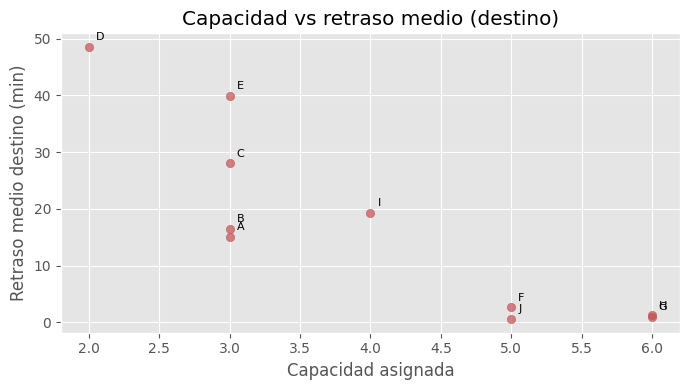

In [45]:
uso_capacidad = trafico.copy()
uso_capacidad['capacidad'] = uso_capacidad.index.map(capacidades.get)
uso_capacidad['retraso_destino_medio'] = retraso_destino['retraso_medio']

print(uso_capacidad.sort_values('vuelos_totales', ascending=False))

fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(uso_capacidad['capacidad'], uso_capacidad['retraso_destino_medio'], color='#c44e52', alpha=0.7)
for nombre, fila in uso_capacidad.iterrows():
    ax.annotate(nombre, (fila['capacidad'], fila['retraso_destino_medio']), textcoords='offset points', xytext=(5,5), fontsize=8)
ax.set_title('Capacidad vs retraso medio (destino)')
ax.set_xlabel('Capacidad asignada')
ax.set_ylabel('Retraso medio destino (min)')
plt.tight_layout()


## 9. Subgrupos: vuelos con vs sin retraso
Separamos vuelos puntuales (retraso = 0) y con retraso (retraso > 0) y repetimos indicadores principales.


In [46]:
resultados_eventos['tiene_retraso'] = resultados_eventos['retraso_calculado'] > 0
subcounts = resultados_eventos['tiene_retraso'].value_counts().rename(index={True: 'con_retraso', False: 'puntual'})
print('Conteo de vuelos por subgrupo:')
print(subcounts)

comparativa = resultados_eventos.groupby('tiene_retraso').agg(
    retraso_medio=('retraso_calculado', 'mean'),
    retraso_max=('retraso_calculado', 'max'),
    duracion_media=('duracion_real_min', 'mean'),
    distancia_media=('distancia', 'mean'),
    espera_cola_media=('espera_en_cola', 'mean')
)
comparativa.index = ['puntual', 'con_retraso']
comparativa


Conteo de vuelos por subgrupo:
tiene_retraso
puntual        2575
con_retraso     202
Name: count, dtype: int64


,retraso_medio,retraso_max,duracion_media,distancia_media,espera_cola_media
puntual,0.000000,0,41.571262,342.390020,0.000000
con_retraso,226.762376,883,271.217822,366.845885,226.762376


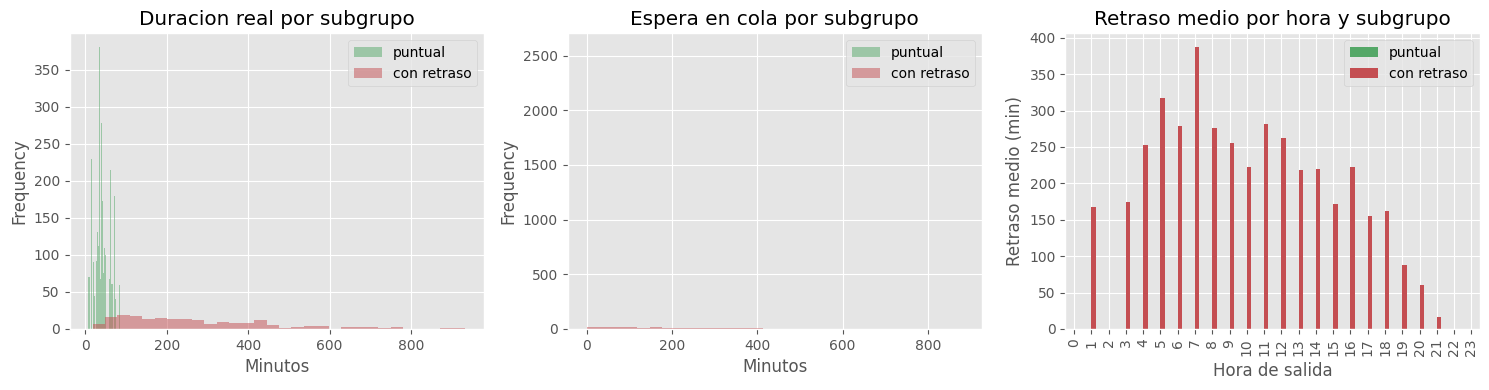

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))
colors = {False: '#55a868', True: '#c44e52'}

# Histograma de duracion real
for flag, grupo in resultados_eventos.groupby('tiene_retraso'):
    grupo['duracion_real_min'].plot(kind='hist', bins=30, alpha=0.5, ax=axes[0], color=colors[flag], label='con retraso' if flag else 'puntual')
axes[0].set_title('Duracion real por subgrupo')
axes[0].set_xlabel('Minutos')
axes[0].legend()

# Espera en cola
for flag, grupo in resultados_eventos.groupby('tiene_retraso'):
    grupo['espera_en_cola'].plot(kind='hist', bins=30, alpha=0.5, ax=axes[1], color=colors[flag], label='con retraso' if flag else 'puntual')
axes[1].set_title('Espera en cola por subgrupo')
axes[1].set_xlabel('Minutos')
axes[1].legend()

# Retraso por hora de salida
retraso_hora_sub = resultados_eventos.groupby(['hora_salida_h', 'tiene_retraso'])['retraso_calculado'].mean().unstack()
retraso_hora_sub.plot(kind='bar', ax=axes[2], color=['#55a868', '#c44e52'])
axes[2].set_title('Retraso medio por hora y subgrupo')
axes[2].set_xlabel('Hora de salida')
axes[2].set_ylabel('Retraso medio (min)')
axes[2].legend(['puntual', 'con retraso'])

plt.tight_layout()


### 9b. Analisis detallado del subgrupo con retraso (> 0 min)
Foco en los vuelos con retraso para ver patrones de nodos, escenarios y colas.


In [48]:
# Filtramos solo vuelos con retraso positivo
vuelos_retraso = resultados_eventos[resultados_eventos['tiene_retraso']]
print(f"Vuelos con retraso: {len(vuelos_retraso)} ({len(vuelos_retraso)/len(resultados_eventos):.2%} del total)")

vuelos_retraso[['retraso_calculado','duracion_real_min','espera_en_cola','distancia']].describe(percentiles=[0.5,0.75,0.9,0.95,0.99])


Vuelos con retraso: 202 (7.27% del total)


,retraso_calculado,duracion_real_min,espera_en_cola,distancia
count,202.000000,202.000000,202.000000,202.000000
mean,226.762376,271.217822,226.762376,366.845885
std,186.520651,186.180039,186.520651,157.197654
min,1.000000,18.000000,1.000000,63.030945
50%,186.000000,235.000000,186.000000,334.131434
75%,341.250000,380.250000,341.250000,515.886605
90%,490.200000,537.700000,490.200000,579.570480
95%,624.400000,663.700000,624.400000,698.501914
99%,744.920000,778.990000,744.920000,703.023619
max,883.000000,933.000000,883.000000,703.023619


#### Distribuciones y percentiles en vuelos con retraso


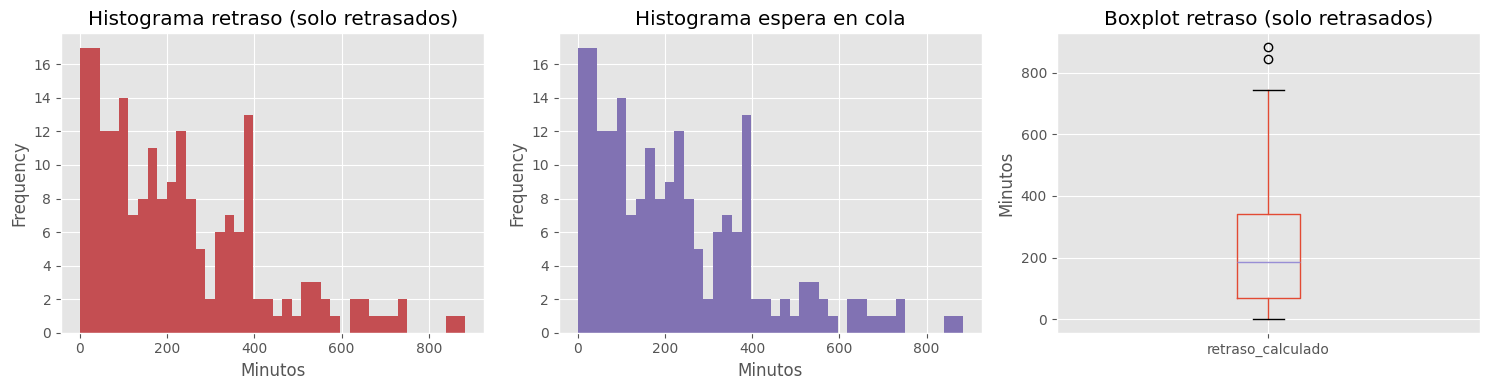

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

vuelos_retraso['retraso_calculado'].plot(kind='hist', bins=40, ax=axes[0], color='#c44e52')
axes[0].set_title('Histograma retraso (solo retrasados)')
axes[0].set_xlabel('Minutos')

vuelos_retraso['espera_en_cola'].plot(kind='hist', bins=40, ax=axes[1], color='#8172b3')
axes[1].set_title('Histograma espera en cola')
axes[1].set_xlabel('Minutos')

vuelos_retraso.boxplot(column=['retraso_calculado'], ax=axes[2])
axes[2].set_title('Boxplot retraso (solo retrasados)')
axes[2].set_ylabel('Minutos')

plt.tight_layout()


#### Retraso por aeropuerto (origen/destino) en subgrupo con retraso


Origen con mayor retraso medio (solo retrasados):
                        media  max    p90
aeropuerto_origen                        
F                  285.727273  737  443.7
B                  267.571429  844  550.0
G                  251.300000  745  548.0
C                  248.933333  668  535.8
I                  247.782609  652  550.0
Destino con mayor retraso medio (solo retrasados):
                         media  max    p90
aeropuerto_destino                        
E                   304.083333  745  648.0
B                   250.235294  629  585.2
D                   233.920000  844  449.7
C                   207.750000  518  383.0
I                   205.357143  737  444.4


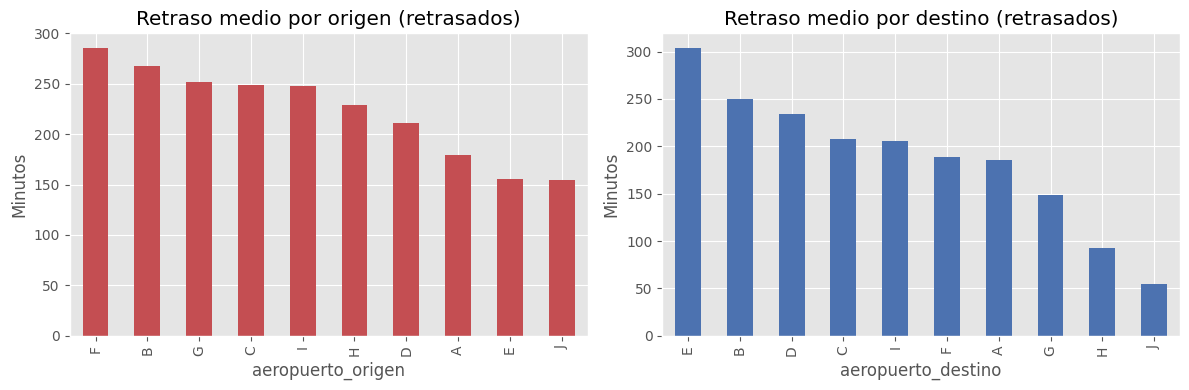

In [50]:
ret_origen_r = vuelos_retraso.groupby('aeropuerto_origen')['retraso_calculado'].agg(media='mean', max='max', p90=lambda x: x.quantile(0.9))
ret_destino_r = vuelos_retraso.groupby('aeropuerto_destino')['retraso_calculado'].agg(media='mean', max='max', p90=lambda x: x.quantile(0.9))

print('Origen con mayor retraso medio (solo retrasados):')
print(ret_origen_r.sort_values('media', ascending=False).head(5))
print('Destino con mayor retraso medio (solo retrasados):')
print(ret_destino_r.sort_values('media', ascending=False).head(5))

fig, axes = plt.subplots(1,2, figsize=(12,4))
ret_origen_r['media'].sort_values(ascending=False).plot(kind='bar', ax=axes[0], color='#c44e52')
axes[0].set_title('Retraso medio por origen (retrasados)')
axes[0].set_ylabel('Minutos')
ret_destino_r['media'].sort_values(ascending=False).plot(kind='bar', ax=axes[1], color='#4c72b0')
axes[1].set_title('Retraso medio por destino (retrasados)')
axes[1].set_ylabel('Minutos')
plt.tight_layout()


#### Escenarios mas problematicos dentro de los retrasados


              cuenta  media  max    p90
N_simulacion                           
9                  2  592.0  626  619.2
43                 4  523.0  745  727.6
41                 4  513.5  718  673.3
24                 2  464.5  550  532.9
19                 5  442.4  668  661.6


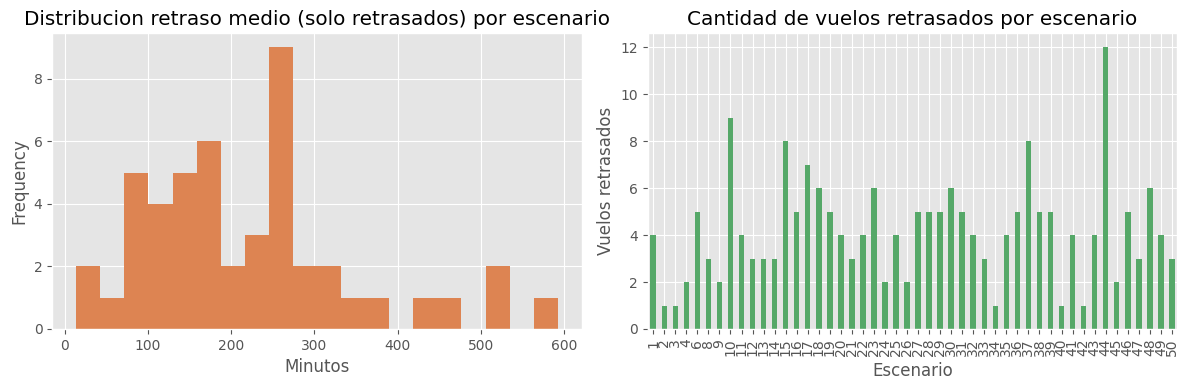

In [51]:
escenas_retraso = vuelos_retraso.groupby('N_simulacion')['retraso_calculado'].agg(
    cuenta='count', media='mean', max='max', p90=lambda x: x.quantile(0.9))
print(escenas_retraso.sort_values('media', ascending=False).head(5))

fig, axes = plt.subplots(1,2, figsize=(12,4))
escenas_retraso['media'].plot(kind='hist', bins=20, ax=axes[0], color='#dd8452')
axes[0].set_title('Distribucion retraso medio (solo retrasados) por escenario')
axes[0].set_xlabel('Minutos')
escenas_retraso['cuenta'].plot(kind='bar', ax=axes[1], color='#55a868')
axes[1].set_title('Cantidad de vuelos retrasados por escenario')
axes[1].set_xlabel('Escenario')
axes[1].set_ylabel('Vuelos retrasados')
plt.tight_layout()


#### Colas en el subgrupo retrasado


Aeropuertos con mayor espera media (solo retrasados):
                 media    max  count
aeropuerto                          
E           304.083333  745.0     36
B           250.235294  629.0     17
D           233.920000  844.0     50
C           207.750000  518.0     36
I           205.357143  737.0     28


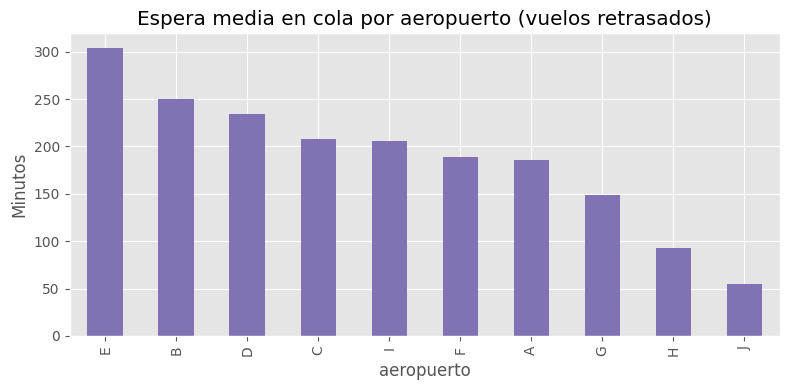

In [52]:
cola_retraso = colas.merge(vuelos_retraso[['N_simulacion','id_vuelo']], on=['N_simulacion','id_vuelo'], how='inner')
cola_retraso['espera_min'].describe(percentiles=[0.5,0.75,0.9,0.95])

cola_aeropuerto_retraso = cola_retraso.groupby('aeropuerto')['espera_min'].agg(media='mean', max='max', count='count')
print('Aeropuertos con mayor espera media (solo retrasados):')
print(cola_aeropuerto_retraso.sort_values('media', ascending=False).head(5))

ax = cola_aeropuerto_retraso['media'].sort_values(ascending=False).plot(kind='bar', figsize=(8,4), color='#8172b3')
ax.set_title('Espera media en cola por aeropuerto (vuelos retrasados)')
ax.set_ylabel('Minutos')
plt.tight_layout()


#### Distancia vs retraso (solo retrasados)


Correlacion distancia-retraso en subgrupo retrasado: -0.069


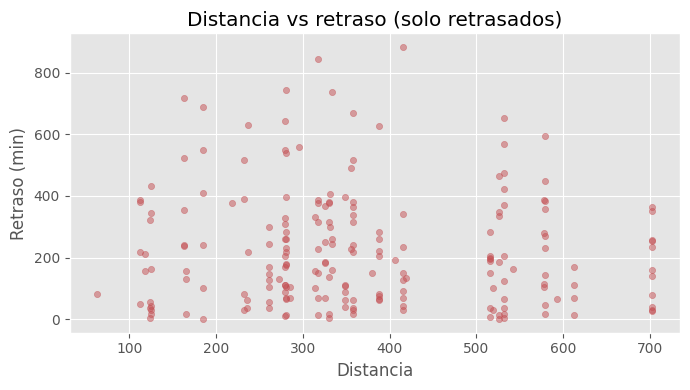

In [53]:
ax = vuelos_retraso.plot.scatter(x='distancia', y='retraso_calculado', alpha=0.5, figsize=(7,4), color='#c44e52')
ax.set_title('Distancia vs retraso (solo retrasados)')
ax.set_xlabel('Distancia')
ax.set_ylabel('Retraso (min)')
plt.tight_layout()

corr_r = vuelos_retraso[['distancia','retraso_calculado']].corr().iloc[0,1]
print(f'Correlacion distancia-retraso en subgrupo retrasado: {corr_r:.3f}')


#### Correlaciones adicionales (vuelos con retraso)
Exploramos relaciones entre retraso, espera en cola, distancia, hora y capacidad/carga de aeropuertos.


                   retraso_calculado  espera_en_cola  distancia  \
retraso_calculado           1.000000        1.000000  -0.069344   
espera_en_cola              1.000000        1.000000  -0.069344   
distancia                  -0.069344       -0.069344   1.000000   
duracion_real_min           0.994869        0.994869   0.031925   
hora_salida_h              -0.276445       -0.276445   0.024615   
cap_origen                  0.065534        0.065534  -0.130096   
cap_destino                -0.130807       -0.130807  -0.159330   
trafico_origen              0.039065        0.039065  -0.026061   
trafico_destino            -0.051628       -0.051628  -0.282370   

                   duracion_real_min  hora_salida_h  cap_origen  cap_destino  \
retraso_calculado           0.994869      -0.276445    0.065534    -0.130807   
espera_en_cola              0.994869      -0.276445    0.065534    -0.130807   
distancia                   0.031925       0.024615   -0.130096    -0.159330   
duracion_

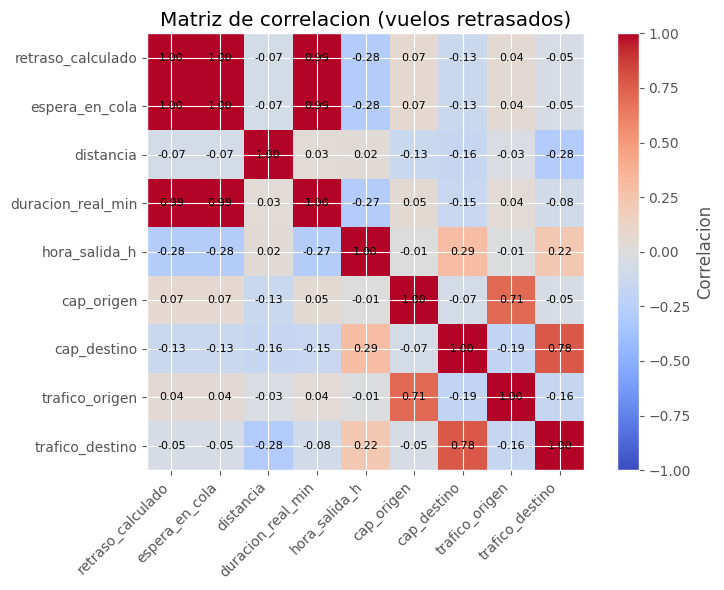

In [54]:
# Enriquecemos subgrupo con capacidad y carga por aeropuerto
vuelos_retraso_enri = vuelos_retraso.copy()
cap_origen = vuelos_retraso_enri['aeropuerto_origen'].map(capacidades)
cap_destino = vuelos_retraso_enri['aeropuerto_destino'].map(capacidades)
traf_origen = vuelos_retraso_enri['aeropuerto_origen'].map(trafico['vuelos_totales'])
traf_destino = vuelos_retraso_enri['aeropuerto_destino'].map(trafico['vuelos_totales'])

vuelos_retraso_enri = vuelos_retraso_enri.assign(
    cap_origen=cap_origen,
    cap_destino=cap_destino,
    trafico_origen=traf_origen,
    trafico_destino=traf_destino,
)

cols_corr = ['retraso_calculado', 'espera_en_cola', 'distancia', 'duracion_real_min', 'hora_salida_h', 'cap_origen', 'cap_destino', 'trafico_origen', 'trafico_destino']
mat_corr = vuelos_retraso_enri[cols_corr].corr()
print(mat_corr)

plt.figure(figsize=(8,6))
plt.imshow(mat_corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlacion')
plt.xticks(range(len(cols_corr)), cols_corr, rotation=45, ha='right')
plt.yticks(range(len(cols_corr)), cols_corr)
plt.title('Matriz de correlacion (vuelos retrasados)')
for i in range(len(cols_corr)):
    for j in range(len(cols_corr)):
        plt.text(j, i, f"{mat_corr.iloc[i,j]:.2f}", ha='center', va='center', color='black', fontsize=8)
plt.tight_layout()


##### Scatter claves (retrasados)


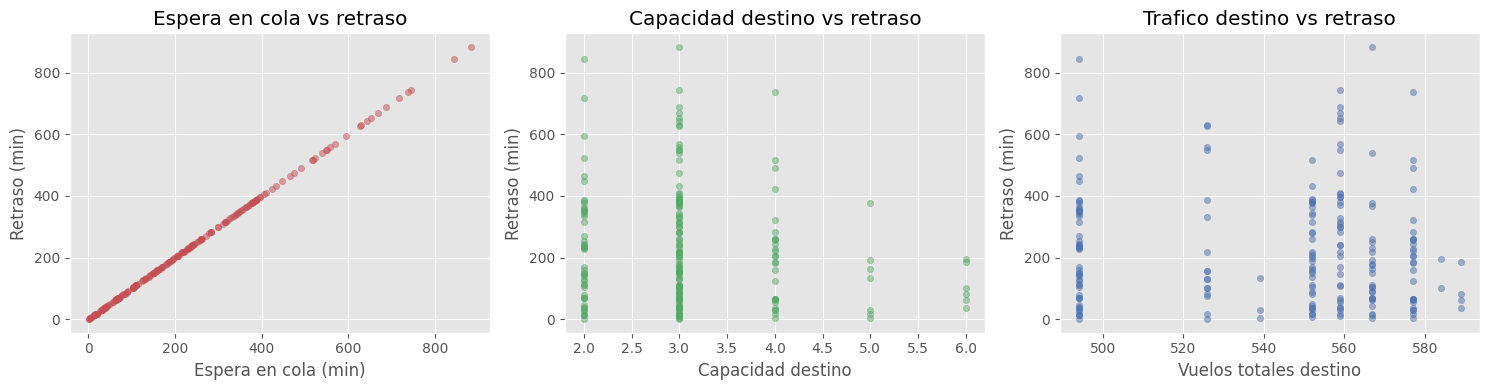

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

vuelos_retraso_enri.plot.scatter(x='espera_en_cola', y='retraso_calculado', alpha=0.5, color='#c44e52', ax=axes[0])
axes[0].set_title('Espera en cola vs retraso')
axes[0].set_xlabel('Espera en cola (min)')
axes[0].set_ylabel('Retraso (min)')

vuelos_retraso_enri.plot.scatter(x='cap_destino', y='retraso_calculado', alpha=0.5, color='#55a868', ax=axes[1])
axes[1].set_title('Capacidad destino vs retraso')
axes[1].set_xlabel('Capacidad destino')
axes[1].set_ylabel('Retraso (min)')

vuelos_retraso_enri.plot.scatter(x='trafico_destino', y='retraso_calculado', alpha=0.5, color='#4c72b0', ax=axes[2])
axes[2].set_title('Trafico destino vs retraso')
axes[2].set_xlabel('Vuelos totales destino')
axes[2].set_ylabel('Retraso (min)')

plt.tight_layout()


##### Hora de salida y cola vs retraso (retrasados)


Correlacion retraso-espera en cola (retrasados): 1.000


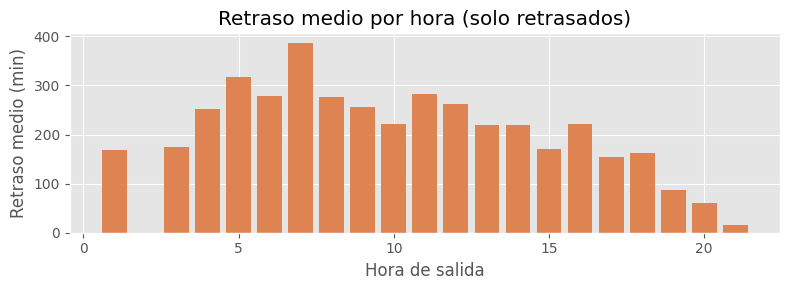

In [56]:
heat_data = vuelos_retraso_enri.pivot_table(index='hora_salida_h', values='retraso_calculado', aggfunc='mean')
plt.figure(figsize=(8,3))
plt.bar(heat_data.index, heat_data['retraso_calculado'], color='#dd8452')
plt.xlabel('Hora de salida')
plt.ylabel('Retraso medio (min)')
plt.title('Retraso medio por hora (solo retrasados)')
plt.tight_layout()

corr_cola = vuelos_retraso_enri[['retraso_calculado','espera_en_cola']].corr().iloc[0,1]
print(f'Correlacion retraso-espera en cola (retrasados): {corr_cola:.3f}')


##### Escenarios: cantidad de retrasados vs retraso medio


              retraso_medio  retraso_max  espera_media  retrasados
N_simulacion                                                      
1                     98.75          182         98.75           4
2                    171.00          171        171.00           1
3                     14.00           14         14.00           1
4                    126.00          181        126.00           2
6                    178.60          317        178.60           5


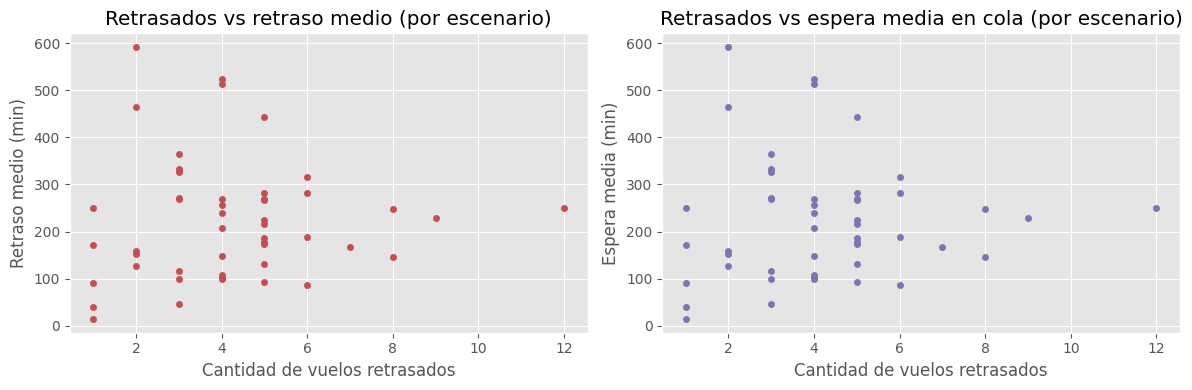

In [57]:
esc_stats = vuelos_retraso_enri.groupby('N_simulacion').agg(
    retraso_medio=('retraso_calculado','mean'),
    retraso_max=('retraso_calculado','max'),
    espera_media=('espera_en_cola','mean'),
    retrasados=('id_vuelo','count')
)
print(esc_stats.head())

fig, axes = plt.subplots(1,2, figsize=(12,4))
esc_stats.plot.scatter(x='retrasados', y='retraso_medio', ax=axes[0], color='#c44e52')
axes[0].set_title('Retrasados vs retraso medio (por escenario)')
axes[0].set_xlabel('Cantidad de vuelos retrasados')
axes[0].set_ylabel('Retraso medio (min)')

esc_stats.plot.scatter(x='retrasados', y='espera_media', ax=axes[1], color='#8172b3')
axes[1].set_title('Retrasados vs espera media en cola (por escenario)')
axes[1].set_xlabel('Cantidad de vuelos retrasados')
axes[1].set_ylabel('Espera media (min)')
plt.tight_layout()


##### Capacidad vs retraso (agregado por aeropuerto)
Relaci?n entre capacidad asignada, carga (vuelos) y retraso medio, tanto en todos los vuelos como solo en los retrasados.


Agregado destino (todos los vuelos):
                    vuelos_totales  retraso_medio  retraso_max  capacidad  \
aeropuerto_destino                                                          
D                              241      48.531120          844          2   
E                              274      39.952555          745          3   
C                              267      28.011236          518          3   
I                              298      19.295302          737          4   
B                              257      16.552529          629          3   
A                              273      14.989011          883          3   
F                              285       2.645614          378          5   
H                              299       1.240803          186          6   
G                              306       0.973856          195          6   
J                              277       0.595668          133          5   

                    vuelos_por_cap  
a

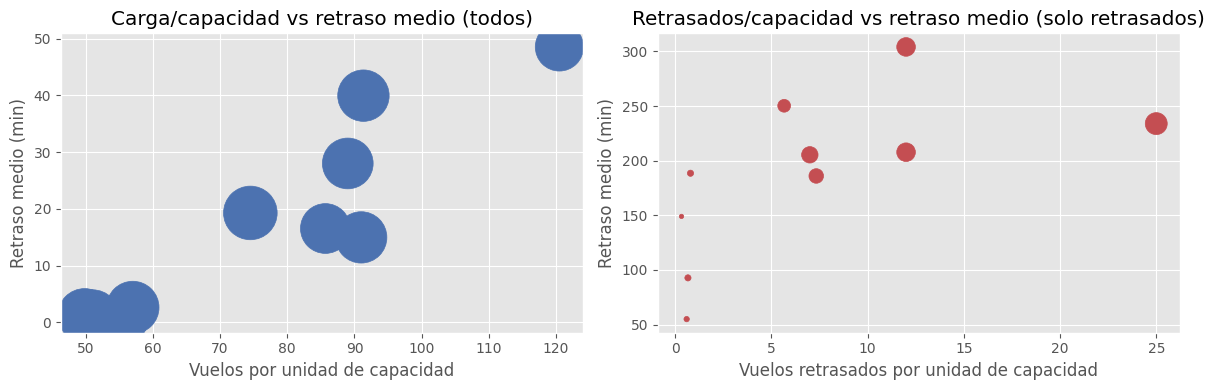

In [58]:
# Agregado por aeropuerto destino
agg_dest = resultados_eventos.groupby('aeropuerto_destino').agg(
    vuelos_totales=('id_vuelo','count'),
    retraso_medio=('retraso_calculado','mean'),
    retraso_max=('retraso_calculado','max')
)
agg_dest['capacidad'] = agg_dest.index.map(capacidades)
agg_dest['vuelos_por_cap'] = agg_dest['vuelos_totales'] / agg_dest['capacidad']

# Solo retrasados
agg_dest_retraso = vuelos_retraso_enri.groupby('aeropuerto_destino').agg(
    vuelos_retrasados=('id_vuelo','count'),
    retraso_medio_r=('retraso_calculado','mean'),
    espera_media_r=('espera_en_cola','mean')
)
agg_dest_retraso['capacidad'] = agg_dest_retraso.index.map(capacidades)
agg_dest_retraso['retrasados_por_cap'] = agg_dest_retraso['vuelos_retrasados'] / agg_dest_retraso['capacidad']

print('Agregado destino (todos los vuelos):')
print(agg_dest.sort_values('retraso_medio', ascending=False))
print('Agregado destino (solo retrasados):')
print(agg_dest_retraso.sort_values('retraso_medio_r', ascending=False))

fig, axes = plt.subplots(1,2, figsize=(12,4))
agg_dest.plot.scatter(x='vuelos_por_cap', y='retraso_medio', s=agg_dest['vuelos_totales']*5, color='#4c72b0', ax=axes[0])
axes[0].set_title('Carga/capacidad vs retraso medio (todos)')
axes[0].set_xlabel('Vuelos por unidad de capacidad')
axes[0].set_ylabel('Retraso medio (min)')

agg_dest_retraso.plot.scatter(x='retrasados_por_cap', y='retraso_medio_r', s=agg_dest_retraso['vuelos_retrasados']*5, color='#c44e52', ax=axes[1])
axes[1].set_title('Retrasados/capacidad vs retraso medio (solo retrasados)')
axes[1].set_xlabel('Vuelos retrasados por unidad de capacidad')
axes[1].set_ylabel('Retraso medio (min)')
plt.tight_layout()

corr_load_delay = agg_dest[['vuelos_por_cap','retraso_medio']].corr().iloc[0,1]
corr_load_delay_r = agg_dest_retraso[['retrasados_por_cap','retraso_medio_r']].corr().iloc[0,1]
print(f"Correlacion carga/capacidad vs retraso medio (todos): {corr_load_delay:.3f}")
print(f"Correlacion retrasados/capacidad vs retraso medio (retrasados): {corr_load_delay_r:.3f}")


###### Capacidad baja vs alta: ?mas retraso?
Relaci?n directa entre capacidad y retraso medio por aeropuerto destino y por aeropuerto origen.


Correlacion capacidad vs retraso medio (todos): -0.868
Correlacion capacidad vs retraso medio (solo retrasados): -0.738
Retraso medio por nivel de capacidad (todos):
capacidad_bin
baja     29.607290
media    19.295302
alta      1.363985
Name: retraso_medio, dtype: float64
Retraso medio por nivel de capacidad (retrasados):
capacidad_bin
baja     236.397725
media    205.357143
alta     121.312500
Name: retraso_medio_r, dtype: float64


C:\Users\alvar\AppData\Local\Temp\ipykernel_18636\3100560463.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(agg_dest.groupby('capacidad_bin')['retraso_medio'].mean())
C:\Users\alvar\AppData\Local\Temp\ipykernel_18636\3100560463.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(agg_dest_retraso.groupby('capacidad_bin')['retraso_medio_r'].mean())


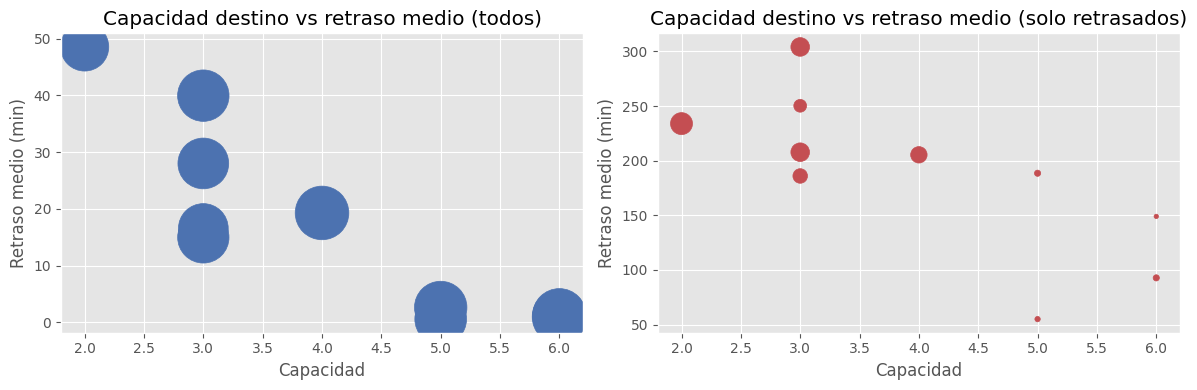

In [59]:
# Retraso por aeropuerto destino con capacidad y trafico
agg_dest = resultados_eventos.groupby('aeropuerto_destino').agg(
    vuelos_totales=('id_vuelo','count'),
    retraso_medio=('retraso_calculado','mean'),
    retraso_max=('retraso_calculado','max')
)
agg_dest['capacidad'] = agg_dest.index.map(capacidades)

# Retraso solo en vuelos retrasados por destino
agg_dest_retraso = vuelos_retraso_enri.groupby('aeropuerto_destino').agg(
    retraso_medio_r=('retraso_calculado','mean'),
    retraso_max_r=('retraso_calculado','max'),
    retrasados=('id_vuelo','count')
)
agg_dest_retraso['capacidad'] = agg_dest_retraso.index.map(capacidades)

# Correlaciones directas
corr_cap_delay = agg_dest[['capacidad','retraso_medio']].corr().iloc[0,1]
corr_cap_delay_r = agg_dest_retraso[['capacidad','retraso_medio_r']].corr().iloc[0,1]
print(f"Correlacion capacidad vs retraso medio (todos): {corr_cap_delay:.3f}")
print(f"Correlacion capacidad vs retraso medio (solo retrasados): {corr_cap_delay_r:.3f}")

# Scatter lineal: capacidad vs retraso medio
fig, axes = plt.subplots(1,2, figsize=(12,4))
agg_dest.plot.scatter(x='capacidad', y='retraso_medio', s=agg_dest['vuelos_totales']*5, color='#4c72b0', ax=axes[0])
axes[0].set_title('Capacidad destino vs retraso medio (todos)')
axes[0].set_xlabel('Capacidad')
axes[0].set_ylabel('Retraso medio (min)')

agg_dest_retraso.plot.scatter(x='capacidad', y='retraso_medio_r', s=agg_dest_retraso['retrasados']*5, color='#c44e52', ax=axes[1])
axes[1].set_title('Capacidad destino vs retraso medio (solo retrasados)')
axes[1].set_xlabel('Capacidad')
axes[1].set_ylabel('Retraso medio (min)')
plt.tight_layout()

# Ranking de aeropuertos con baja capacidad y alto retraso
agg_dest['capacidad_bin'] = pd.qcut(agg_dest['capacidad'], q=3, labels=['baja','media','alta'])
print("Retraso medio por nivel de capacidad (todos):")
print(agg_dest.groupby('capacidad_bin')['retraso_medio'].mean())

agg_dest_retraso['capacidad_bin'] = pd.qcut(agg_dest_retraso['capacidad'], q=3, labels=['baja','media','alta'])
print("Retraso medio por nivel de capacidad (retrasados):")
print(agg_dest_retraso.groupby('capacidad_bin')['retraso_medio_r'].mean())


###### Scatter de retraso absoluto vs capacidad
Cada vuelo como punto: capacidad del aeropuerto vs retraso individual (sin promediar).


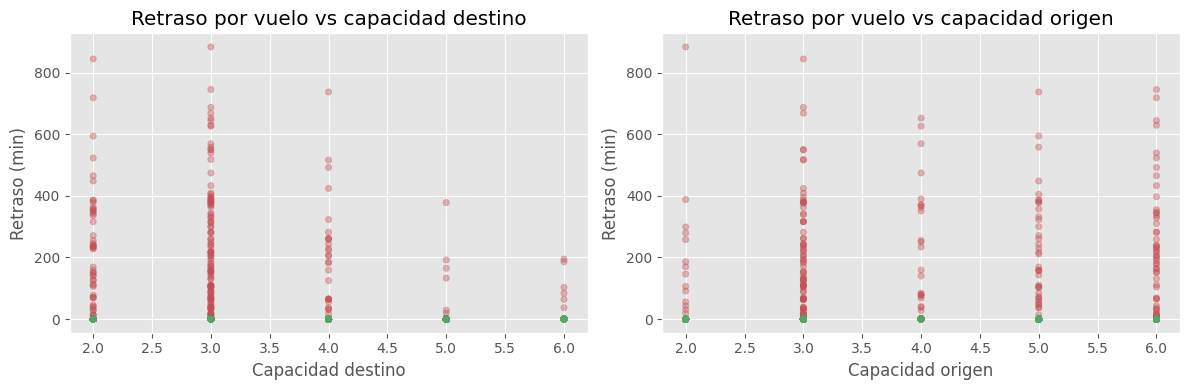

In [60]:
# Capacidad mapeada por aeropuerto
resultados_eventos['cap_destino'] = resultados_eventos['aeropuerto_destino'].map(capacidades)
resultados_eventos['cap_origen'] = resultados_eventos['aeropuerto_origen'].map(capacidades)

fig, axes = plt.subplots(1,2, figsize=(12,4))

resultados_eventos.plot.scatter(x='cap_destino', y='retraso_calculado', alpha=0.4,
                                color=resultados_eventos['tiene_retraso'].map({True:'#c44e52', False:'#55a868'}), ax=axes[0])
axes[0].set_title('Retraso por vuelo vs capacidad destino')
axes[0].set_xlabel('Capacidad destino')
axes[0].set_ylabel('Retraso (min)')

resultados_eventos.plot.scatter(x='cap_origen', y='retraso_calculado', alpha=0.4,
                                color=resultados_eventos['tiene_retraso'].map({True:'#c44e52', False:'#55a868'}), ax=axes[1])
axes[1].set_title('Retraso por vuelo vs capacidad origen')
axes[1].set_xlabel('Capacidad origen')
axes[1].set_ylabel('Retraso (min)')

plt.tight_layout()


###### Visualizacion colas: top aeropuertos por longitud maxima
Barras comparando longitud de cola maxima y espera media en esos nodos.


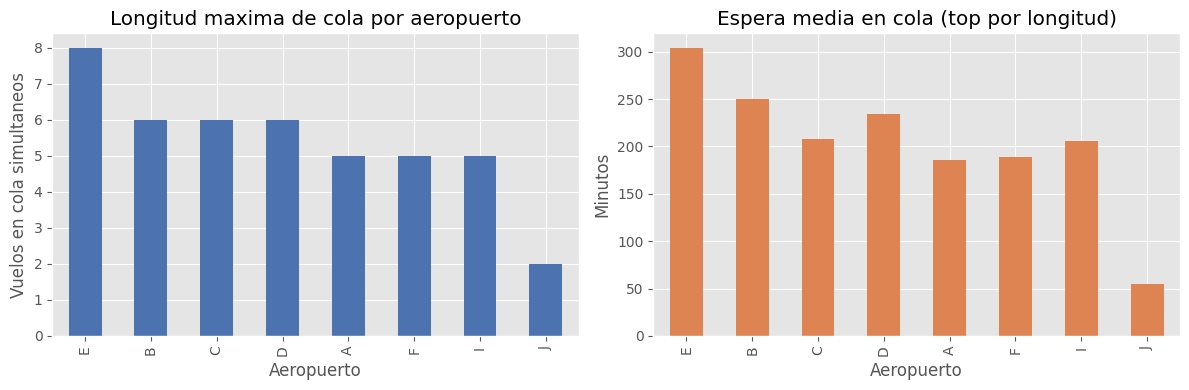

In [61]:
# Seleccionamos top por longitud maxima de cola (tabla ya calculada antes)
top_cola = cola_por_aeropuerto.sort_values('longitud_max_cola', ascending=False).head(8)

fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Longitud maxima de cola
top_cola['longitud_max_cola'].plot(kind='bar', ax=axes[0], color='#4c72b0')
axes[0].set_title('Longitud maxima de cola por aeropuerto')
axes[0].set_ylabel('Vuelos en cola simultaneos')
axes[0].set_xlabel('Aeropuerto')

# Espera media en esos aeropuertos
top_cola['espera_media_min'].plot(kind='bar', ax=axes[1], color='#dd8452')
axes[1].set_title('Espera media en cola (top por longitud)')
axes[1].set_ylabel('Minutos')
axes[1].set_xlabel('Aeropuerto')

plt.tight_layout()


###### Colas, capacidad y retrasos por aeropuerto
Relacionamos capacidad, volumen de vuelos, colas y retrasos por aeropuerto.


Resumen por aeropuerto (capacidad, vuelos, colas y retrasos):
   capacidad  vuelos_totales  retrasos_dest  retraso_medio_dest  \
D          2             494             50           48.531120   
E          3             559             36           39.952555   
C          3             552             36           28.011236   
I          4             577             28           19.295302   
B          3             526             17           16.552529   
A          3             567             22           14.989011   
F          5             567              4            2.645614   
H          6             589              4            1.240803   
G          6             584              2            0.973856   
J          5             539              3            0.595668   

   retraso_max_dest  vuelos_en_cola  espera_media_min  longitud_max_cola  \
D               844              50        233.920000                  6   
E               745              36        304.0

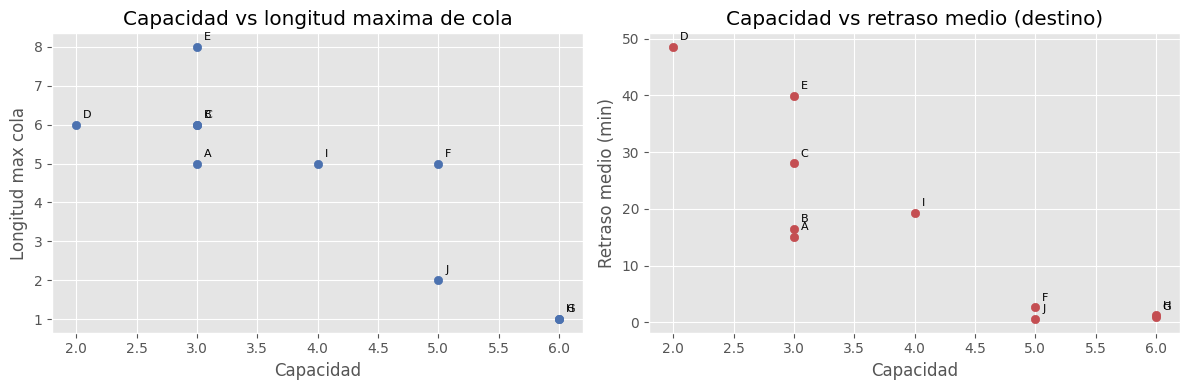

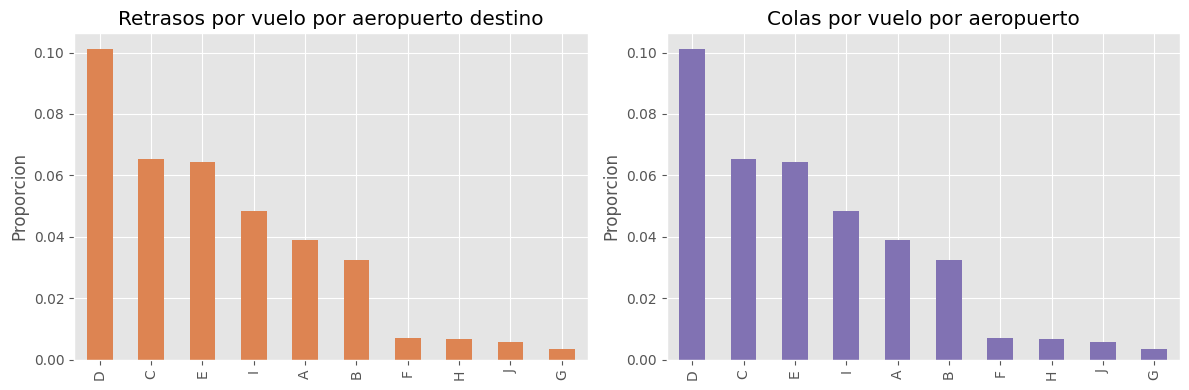

In [62]:
# Agregado por aeropuerto destino
agg = pd.DataFrame(index=capacidades.keys())
agg['capacidad'] = agg.index.map(capacidades)
agg['vuelos_totales'] = trafico['vuelos_totales']
agg['retrasos_dest'] = (resultados_eventos['retraso_calculado']>0).groupby(resultados_eventos['aeropuerto_destino']).sum()
agg['retraso_medio_dest'] = resultados_eventos.groupby('aeropuerto_destino')['retraso_calculado'].mean()
agg['retraso_max_dest'] = resultados_eventos.groupby('aeropuerto_destino')['retraso_calculado'].max()

# A\u00f1adimos estadisticas de colas
agg = agg.join(cola_por_aeropuerto[['vuelos_en_cola','espera_media_min','longitud_max_cola']])
agg['colaciones_por_vuelo'] = agg['vuelos_en_cola'] / agg['vuelos_totales']
agg['retrasos_por_vuelo'] = agg['retrasos_dest'] / agg['vuelos_totales']

print('Resumen por aeropuerto (capacidad, vuelos, colas y retrasos):')
print(agg.sort_values('retraso_medio_dest', ascending=False))

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].scatter(agg['capacidad'], agg['longitud_max_cola'], color='#4c72b0')
axes[0].set_title('Capacidad vs longitud maxima de cola')
axes[0].set_xlabel('Capacidad')
axes[0].set_ylabel('Longitud max cola')
for nombre, fila in agg.iterrows():
    axes[0].annotate(nombre, (fila['capacidad'], fila['longitud_max_cola']), textcoords='offset points', xytext=(5,5), fontsize=8)

axes[1].scatter(agg['capacidad'], agg['retraso_medio_dest'], color='#c44e52')
axes[1].set_title('Capacidad vs retraso medio (destino)')
axes[1].set_xlabel('Capacidad')
axes[1].set_ylabel('Retraso medio (min)')
for nombre, fila in agg.iterrows():
    axes[1].annotate(nombre, (fila['capacidad'], fila['retraso_medio_dest']), textcoords='offset points', xytext=(5,5), fontsize=8)
plt.tight_layout()

fig, axes = plt.subplots(1,2, figsize=(12,4))
agg.sort_values('retrasos_por_vuelo', ascending=False)['retrasos_por_vuelo'].plot(kind='bar', ax=axes[0], color='#dd8452')
axes[0].set_title('Retrasos por vuelo por aeropuerto destino')
axes[0].set_ylabel('Proporcion')

agg.sort_values('colaciones_por_vuelo', ascending=False)['colaciones_por_vuelo'].plot(kind='bar', ax=axes[1], color='#8172b3')
axes[1].set_title('Colas por vuelo por aeropuerto')
axes[1].set_ylabel('Proporcion')
plt.tight_layout()


###### Pie chart unico: distribucion de vuelos con retraso por aeropuerto destino


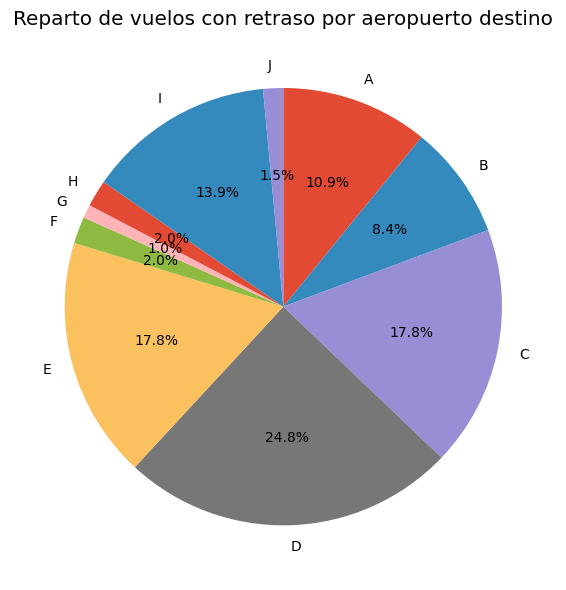

In [63]:
plt.figure(figsize=(6,6))
agg['retrasos_dest'].plot(kind='pie', autopct='%1.1f%%', startangle=90, counterclock=False)
plt.ylabel('')
plt.title('Reparto de vuelos con retraso por aeropuerto destino')
plt.tight_layout()
